In [5]:
# ==============================================================
# 📂 Google Drive + Package Setup (Module 4 - Clustering)
# ==============================================================

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set project/data paths
PROJECT_PATH = "/content/drive/MyDrive/el-roi"
DATA_PATH = os.path.join(PROJECT_PATH, "data")
os.makedirs(DATA_PATH, exist_ok=True)

print(f"✅ Project directory: {PROJECT_PATH}")
print(f"✅ Data directory: {DATA_PATH}")

# ==============================================================
# 📦 Install Required Libraries
# ==============================================================
!pip install --quiet sentence-transformers hdbscan


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Project directory: /content/drive/MyDrive/el-roi
✅ Data directory: /content/drive/MyDrive/el-roi/data


In [6]:
# ==============================================================
# MODULE 4: Semantic Clustering with Sentence-BERT + HDBSCAN
# ==============================================================

import pandas as pd
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load pre-trained multilingual sentence embedding model
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

def generate_embeddings(texts):
    """
    Generate sentence embeddings for a list of texts using Sentence-BERT.
    """
    return model.encode(texts, show_progress_bar=True)

def cluster_embeddings(embeddings, min_cluster_size=2):
    """
    Cluster sentence embeddings using HDBSCAN.
    Returns cluster labels (one per document).
    """
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean",
        cluster_selection_method="eom"
    )
    cluster_labels = clusterer.fit_predict(embeddings_scaled)
    return cluster_labels

# --------------------------------------------------------------
# 📂 Load NER-enriched data
# --------------------------------------------------------------
ner_input_path = os.path.join(DATA_PATH, "articles_ner.jsonl")
if not os.path.exists(ner_input_path):
    raise FileNotFoundError(f"❌ Could not find {ner_input_path}. Please run Module 3 first.")

df_ner = pd.read_json(ner_input_path, lines=True)

# --------------------------------------------------------------
# 🚀 Run Embedding + Clustering Pipeline
# --------------------------------------------------------------
texts = df_ner["translated_summary"].fillna("").tolist()
print(f"📄 Embedding {len(texts)} documents...")

embeddings = generate_embeddings(texts)
cluster_labels = cluster_embeddings(embeddings, min_cluster_size=2)

# Attach cluster IDs
df_ner["cluster_id"] = cluster_labels

# --------------------------------------------------------------
# 💾 Save Clustered Output
# --------------------------------------------------------------
cluster_output_path = os.path.join(DATA_PATH, "articles_clustered.jsonl")
df_ner.to_json(cluster_output_path, orient="records", lines=True, force_ascii=False)

print(f"✅ Clustering complete. Found {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)} clusters.")
print(f"✅ Saved clustered data to: {cluster_output_path}")

# --------------------------------------------------------------
# 🔍 Preview
# --------------------------------------------------------------
df_ner[["translated_summary", "cluster_id"]].head()


📄 Embedding 145 documents...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Clustering complete. Found 2 clusters.
✅ Saved clustered data to: /content/drive/MyDrive/el-roi/data/articles_clustered.jsonl


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


translated_summary  cluster_id
0  The White House envoy is seen with Putin in Mo...           0
1  Indian exports will be subject to a final tax ...          -1
2  The Lula Government considers to include the e...          -1
3  American allies in Europe manage to strengthen...          -1
4  The rise of barriers to the most intense trade...          -1

/tmp/ipython-input-93903099.py:29: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Visualizing cluster distribution...


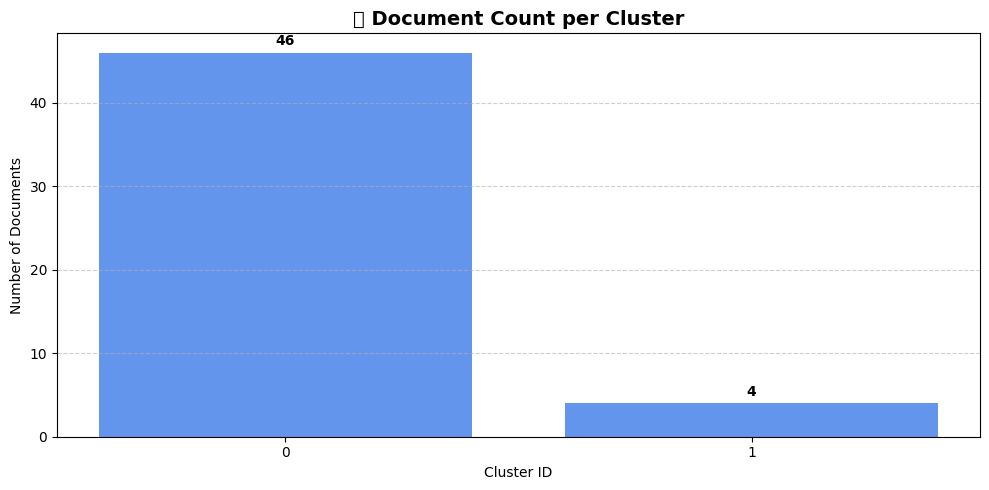

In [7]:
# ==============================================================
# 📊 Cluster Distribution Chart
# ==============================================================

import matplotlib.pyplot as plt

def plot_cluster_distribution(df, exclude_noise=True):
    """
    Plots the number of documents per cluster.
    """
    label_counts = df["cluster_id"].value_counts().sort_index()

    if exclude_noise:
        label_counts = label_counts[label_counts.index != -1]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(label_counts.index.astype(str), label_counts.values, color="cornflowerblue")

    # Add counts on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval),
                 ha="center", va="bottom", fontsize=10, fontweight="bold")

    plt.title("🧠 Document Count per Cluster", fontsize=14, fontweight="bold")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Documents")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# 🚀 Display the chart
# --------------------------------------------------------------
print("\n📊 Visualizing cluster distribution...")
plot_cluster_distribution(df_ner)
